# pycoalescence islands example simulation

The scenario outlined here simulates four islands (A-D) totalling 100000 individuals. The islands contain 50000, 25000, 5000 and 20000 individuals respectively. The dispersal probabilities are given in *dispersal_probabilities.csv* and are shown in the data frame below.

Note that the code refers to this scenario as patches on a patched landscape, instead of islands in an archipelago, as patches is more general.

In [1]:
import itertools
import pandas as pd
dispersal_probs = pd.read_csv("dispersal_probabilities.csv", index_col=0)
dispersal_probs

,A,B,C,D
A,0.50,0.25,0.15,0.10
B,0.30,0.65,0.01,0.04
C,0.05,0.01,0.85,0.09
D,0.10,0.25,0.30,0.40


## Generate the dispersal and density maps

We can make use of the ``PatchedLandscape`` class to generate the dispersal and density maps. In this case, we already have dispersal probabilities as a matrix, so this is not necessary, but is shown to highlight how this process works.

In [2]:
import os
from pycoalescence.patched_landscape import PatchedLandscape

In [3]:
# Define our density and dispersals maps - these will be created below
density_map = os.path.join("maps", "island_density.tif")
dispersal_map = os.path.join("maps", "dispersal_probabilities.tif")

Generate the patches landscape containing our patches (islands)

In [4]:
# Delete the outputs if they exist
for each in [density_map, dispersal_map]:
	if os.path.exists(each):
		os.remove(each)
island_landscape = PatchedLandscape(output_fine_map=density_map,
									output_dispersal_map=dispersal_map)
# Define the densities for each island
densities = {"A" : 50000, "B" : 25000, "C" : 5000, "D" : 20000}
# Generate a dictionary for each island for the dispersal probabilities to every other island, and itself
# All the dictionaries are added as patches to the PatchedLandscape
for src_id, row in dispersal_probs.iteritems():
	dst_probs = {}
	for dst_id, prob in row.iteritems():
		dst_probs[dst_id] = prob
	island_landscape.add_patch(id=src_id, density=densities[src_id], dispersal_probabilities=dst_probs)

Write out out map files - note that the dispersal probability map is scaled to be a cumulative probability summing to 1 across rows. The density map will be a map containing a single row (islands A, B, C and D) as the spatial structure is not important.

In [5]:
# Generates maps/dispersal_probabilities.tif and maps/island_density.tif
island_landscape.generate_files()

In [6]:
fragment_csv = os.path.join("output", "fragments.csv")
# Delete the fragment csv if it exists
if os.path.exists(fragment_csv):
	os.remove(fragment_csv)
# Generate output/fragments.csv which contains information for each of our islands
island_landscape.generate_fragment_csv(fragment_csv)

### Display the dispersal map

This is a map-of-maps, where dispersal is from each row index to each row index.

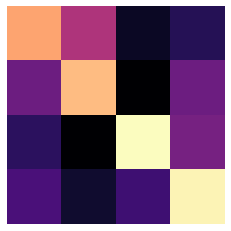

In [7]:
import matplotlib.pyplot as plt
from pycoalescence import Map
m = Map(dispersal_map)
m.open()
f = plt.figure()
plt.imshow(m.data, cmap='magma', interpolation='nearest')
plt.axis('off')
plt.show()
f.savefig(os.path.join("output", "dispersal_probs_fig.png"), bbox_inches='tight')


### Display the cumulative dispersal probability map
This is the map-of-maps, as above, but with values are stored as a cumulative probability, summing to 1 across rows.

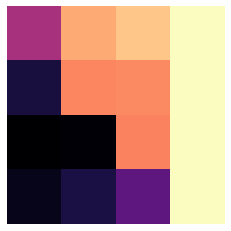

In [8]:
import numpy as np
tmp = np.cumsum(m.data, axis=1)
f = plt.figure()
plt.imshow(tmp, cmap='magma', interpolation='nearest')
plt.axis('off')
plt.show()
f.savefig(os.path.join("output", "cum_dispersal_probs_fig.png"), bbox_inches='tight')


## Perform the coalescence simulation

The method of simulation is now identical to that shown in example_fragmented_landscape.ipynb, except that we provide a dispersal probability map instead of a dispersal method.

Because the landscape structure here is restricted to the islands we provided, the simulation should take only a few seconds.

In [9]:
from pycoalescence import Simulation
sim = Simulation(logging_level=20)
sim.set_simulation_parameters(seed=1, job_type=3, output_directory="output", min_speciation_rate=0.0001)
sim.set_map_files(sample_file="null", fine_file=density_map, dispersal_map=dispersal_map)
sim.run()

Checking folder existance...maps/island_density.tif exists.               
Checking folder existance...output exists.               
Checking folder existance...done.                                                                
Checking for unfinished simulations...done.
No files found containing unfinished simulations.
*************************************************
Setting up simulation...
Dispersal (tau, sigma): 1, 1
Dispersal method: normal
Fine map
-file: maps/island_density.tif
-dimensions: (4, 1)
-offset: (0, 0)
Coarse map
-file: none
-dimensions: (4, 1)
-offset: (0, 0)
-scale: 1
Sample grid
-dimensions: (4, 1)
-optimised area: (4, 1)
-optimised offsets: (0, 0)
Seed: 1
Speciation rate: 0.0001
Job Type: 3
Max time: 3600
Deme: 1
Deme sample: 1
Output directory: output
Disp Rel Cost: 1
Times:  0.0
Checking folder existance...maps/island_density.tif exists.               
Importing maps/island_density.tif 
No data value is: -99
Getting geo transform...done.
Affine transform is 

## Analyse the simulations

Apply additional speciation rates and obtain the species richness for each site.
Additionally, calculate the proportion of similar species pairwise between each site.

Here we generate a csv containing the island biodiversity metrics, such as the number of shared and unique species for each pair of islands.

In [10]:
from pycoalescence import CoalescenceTree
coal_tree = CoalescenceTree(sim)
coal_tree.set_speciation_parameters(speciation_rates=[0.0001, 0.001, 0.01], 
									record_fragments=os.path.join("output", "fragments.csv"))
coal_tree.apply()
output=[]
for ref in coal_tree.get_community_references():
	global_species = set(x[0] for x in coal_tree.get_species_abundances(reference=ref))
	global_species_richness = len(global_species)
	fragment_species = {}
	fragment_species_richness = {}
	speciation_rate = coal_tree.get_community_parameters(ref)["speciation_rate"]
	output.append({"fragment" : "whole", 
					  "species_richness": global_species_richness,
					  "endemics" : 0, "speciation_rate" : speciation_rate,
				   "number_individuals" : coal_tree.get_number_individuals(community_reference=ref)})
	for fragment in coal_tree.get_fragment_list(ref):
		fragment_species[fragment] = set([x[0] for x in coal_tree.get_species_abundances(fragment=fragment, reference=ref)])
		fragment_species_richness[fragment] = len(fragment_species[fragment])
	for fragment in coal_tree.get_fragment_list(ref):
		ext_species = set(itertools.chain(*[[x for x in val] for
											k, val in fragment_species.items() if k != fragment]))
		endemic_species = set([x for x in fragment_species[fragment] if x not in ext_species])
		output.append({"fragment" : fragment, 
					  "species_richness": fragment_species_richness[fragment],
					  "endemics" : len(endemic_species),
					  "speciation_rate" : speciation_rate,
					   "number_individuals" : coal_tree.get_number_individuals(fragment=fragment,
																			   community_reference=ref)})
output_df = pd.DataFrame(output)
output_df.to_csv(os.path.join("results", "island_biodiversity.csv"))